# Practice Session 07: Hubs and authorities
<font size="+2" color="blue">Additional results: country clusters</font>


# 1. Read mapping of codes to country names

In [1]:
import csv
import gzip
import io
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np

In [2]:
INPUT_NAMES_FILENAME = "trade-countries.csv.gz"
INPUT_TRADE_1980 = "trade_1980-flows.csv.gz"
INPUT_TRADE_2013 = "trade_2013-flows.csv.gz"

# Organisation for Economic Co-operation and Development
OECD = set(["AUS", "AUT", "BEL", "CAN", "CHL", "COL", "CZE", "DNK", "EST", "FIN", "FRA",
        "DEU", "GRC", "HUN", "ISL", "IRL", "ISR", "ITA", "JPN", "KOR", "LVA", "LTU",
        "LUX", "MEX", "NLD", "NOR", "NZL", "POL", "CHE", "ESP", "GBR", "PRT", "SVK",
        "SVN", "SWE", "TUR", "USA"])

# Brazil, Russia, India, China, and South Africa
BRICS = set(["BRA", "RUS", "IND", "CHN", "ZAF"])

# COUNTRIES
COUNTRIES = OECD.union(BRICS)

In [3]:
id2name = {}

In [4]:
# Open a compressed file for reading in text mode
with gzip.open(INPUT_NAMES_FILENAME, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    for record in reader:
        code = record["code"]
        name = record["name"]
        id2name[code] = name

In [5]:
# LEAVE AS-IS

print(id2name["ZAF"])

South Africa


# 2. Read flows data into two graphs

In [6]:
g1980 = nx.DiGraph()

with gzip.open(INPUT_TRADE_1980, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    for record in reader:
        country1 = record["country1"]
        country2 = record["country2"]
        flow = record["flow"]
        amount = float(record["amount"]) if len(record["amount"]) > 0 else 0.0 # Si existe un amount, len>0, se transforma en float, si no daría error
        amount = int(round(amount/1000000)) # Se divide entre 1M, se redondea y se transforma en int
        if country1 != country2: # Evita ejecutar el código y los selfloops cuando ambos country son el mismo
          if amount > 0 and country1 in COUNTRIES and country2 in COUNTRIES: # Si el amount < 0 , no hay intercambio. Ambos countries deben pertenecer al grupo seleccionado previamente, COUNTRIES.
            if flow == "Export": # Exportaciones
              
              if country1 not in g1980.nodes(): # Se evitan duplicados
                g1980.add_node(country1)
              if country2 not in g1980.nodes(): 
                g1980.add_node(country2)

              g1980.add_edge(country1, country2, weight = amount) # Exportaciones
            else: # Importaciones
              g1980.add_edge(country2, country1, weight = amount)


g2013 = nx.DiGraph()

with gzip.open(INPUT_TRADE_2013, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    for record in reader:
        country1 = record["country1"]
        country2 = record["country2"]
        flow = record["flow"]
        amount = float(record["amount"]) if len(record["amount"]) > 0 else 0.0
        amount = int(round(amount/1000000))
        if country1 != country2:
          if amount > 0 and country1 in COUNTRIES and country2 in COUNTRIES:
            if flow == "Export":
              
              if country1 not in g2013.nodes():
                g2013.add_node(country1)
              if country2 not in g2013.nodes():
                g2013.add_node(country2)

              g2013.add_edge(country1, country2, weight = amount)
            else:
              g2013.add_edge(country2, country1, weight = amount)


In [7]:
# LEAVE AS-IS

for exporter in ["BRA", "ZAF"]:
    for importer in ["FRA", "PRT"]:
        print("In 1980, {:s} ({:s}) exported to {:s} ({:s}) goods and services for {:,d} USD millions".format(
            exporter, id2name[exporter], importer, id2name[importer], 
            g1980.get_edge_data(exporter, importer)["weight"]) )

        print("by 2013, it exported {:,d} USD millions".format(g2013.get_edge_data(exporter, importer)["weight"]))
        print("")
    

In 1980, BRA (Brazil) exported to FRA (France) goods and services for 99 USD millions
by 2013, it exported 372 USD millions

In 1980, BRA (Brazil) exported to PRT (Portugal) goods and services for 13 USD millions
by 2013, it exported 92 USD millions

In 1980, ZAF (South Africa) exported to FRA (France) goods and services for 100 USD millions
by 2013, it exported 89 USD millions

In 1980, ZAF (South Africa) exported to PRT (Portugal) goods and services for 5 USD millions
by 2013, it exported 12 USD millions



In [8]:
def sum_weights(graph, direction, weight_key):
  weight = 0 # Se establece el peso en 0
  for u, v, d in graph.edges(data=True): # Se itera por cada enlace
    w = d['weight'] # Se obtiene el peso
    if (direction  == "in" and weight_key == v) or (direction == "out" and weight_key == u):  # Si la dirección es in en importaciones y el país(weight_key) es igual al segundo nodo v, es un importacion y se suma el weight, al revés para las exportaciones
      weight += w
  return weight

In [9]:
exports1980 = {}
imports1980 = {}
exports2013 = {}
imports2013 = {}

for country in g1980.nodes(): # Se itera para todos los paises
  exports1980[country] = sum_weights(g1980,"out",country)  
  imports1980[country] = sum_weights(g1980,"in",country)  

for country in g2013.nodes():
  exports2013[country] = sum_weights(g2013,"out",country)  
  imports2013[country] = sum_weights(g2013,"in",country)


In [10]:
# LEAVE AS-IS

for country in ['FRA', 'CHN']:
    print("{:s} exported {:,d} USD Million in 1980 and {:,d} USD Million in 2013 ({:.1f} times),".format(
        id2name[country], exports1980[country], exports2013[country], exports2013[country]/exports1980[country]
    ))
    print(" and imported {:,d} USD Million in 1980 and {:,d} USD Million in 2013 ({:.1f} times).".format(
        imports1980[country], imports2013[country], imports2013[country]/imports1980[country]
    ))
    print()

France exported 6,923 USD Million in 1980 and 39,326 USD Million in 2013 (5.7 times),
 and imported 7,951 USD Million in 1980 and 48,557 USD Million in 2013 (6.1 times).

China (People's Republic of) exported 715 USD Million in 1980 and 100,868 USD Million in 2013 (141.1 times),
 and imported 1,100 USD Million in 1980 and 49,216 USD Million in 2013 (44.7 times).



In [11]:
# LEAVE AS-IS

sorted_countries = sorted(COUNTRIES)

flowsData = {
    'exp1980': [(exports1980[c] if c in exports1980 else 0) for c in sorted_countries],
    'imp1980': [(imports1980[c] if c in imports1980 else 0) for c in sorted_countries],
    'exp2013': [(exports2013[c] if c in exports2013 else 0) for c in sorted_countries], 
    'imp2013': [(imports2013[c] if c in imports2013 else 0) for c in sorted_countries],
}

flowsDF = pd.DataFrame(flowsData, index=sorted_countries)
flowsDF

,exp1980,imp1980,exp2013,imp2013
AUS,1264,1283,16608,13342
AUT,1180,1686,12332,13050
BEL,4331,4876,34515,34057
BRA,1078,873,8069,9519
CAN,4839,4328,36239,34327
CHE,2114,2817,16294,16749
CHL,259,246,5527,5158
CHN,715,1100,100868,49216
COL,294,291,2859,2787
CZE,0,0,12483,11065


# 3. Draw the exports graphs

In [12]:
def plotGraph(g, exports):
  NODE_SIZE_MULTIPLIER = 0.05
  EDGE_WIDTH_MULTIPLIER = 0.3
  
  plt.figure(figsize=(20,12))

  # Compute node sizes as a function of total exports
  node_sizes = []
  for node in g.nodes():
      node_sizes.append(exports[node] * NODE_SIZE_MULTIPLIER)

  # Compute edge widths as a function of exports
  edge_widths = []
  for u, v, d in g.edges(data=True):
      weight = math.log(d['weight'])*EDGE_WIDTH_MULTIPLIER
      edge_widths.append(weight)

  # Determine node positions
  pos = nx.spring_layout(g, iterations=100, weight="weight")

  # Draw nodes
  nx.draw_networkx_nodes(g, pos, node_color="yellow", node_size=node_sizes)

  # Draw edges
  nx.draw_networkx_edges(g, pos, width=edge_widths, )

  # Draw labels and display graph
  _ = nx.draw_networkx_labels(g, pos)

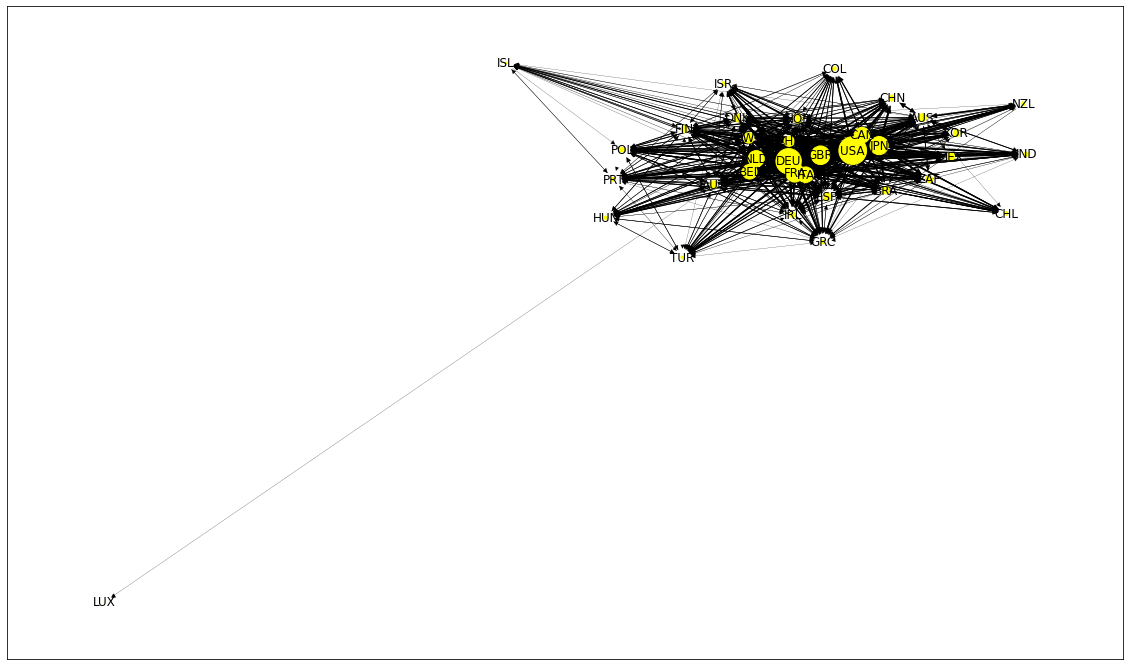

In [13]:
plotGraph(g1980, exports1980)

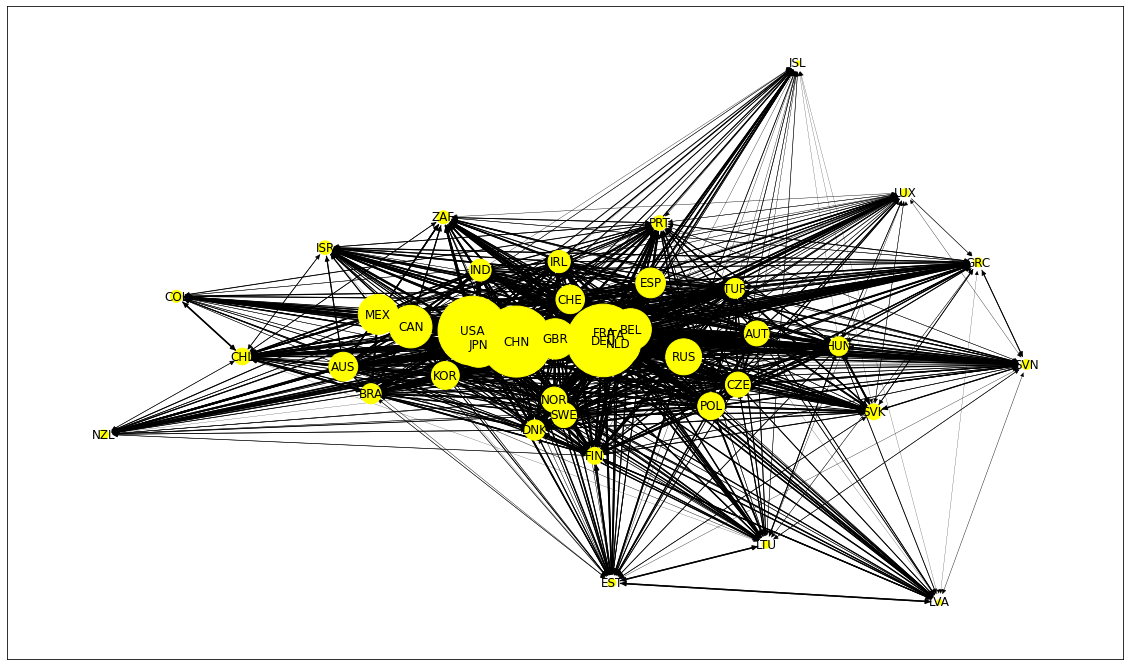

In [14]:
plotGraph(g2013, exports2013)


Una de la mayores similitudes es que ambas comparten un núcleo central donde se concentran una gran cantidad de enlaces, relaciones comerciales, en cuyo epicentro se encuentran Gran Bretaña, Alemania, USA, Francia, etc. Esto sucede tanto en 1980 como en 2013, a pesar de esto, en 2013, aparecen nuevos nodos en el centro tales como Mexico, China, etc. Una de las principales diferencias es que el número de nodos y enlaces es superior en 2013 que en 1980 lo que significa que se entablaron nuevas relaciones comerciales entre distintos y nuevos paises. Esto se ve claramente en Luxemburgo, que al principio es un nodo de apenas grado 1 y en 2013 ya posee un grado mucho mayor.

# 4. Compute hubs and authorities

In [15]:
def normalize(d):
  sum = 0
  for key in d: # Itera para conseguir la suma 
    sum += d[key]
  for key in d: # Normaliza cada valor
    d[key] /= sum
  return d

In [16]:
# LEAVE AS-IS

print(normalize({"a": 60, "b": 120, "c":20}))

{'a': 0.3, 'b': 0.6, 'c': 0.1}


In [17]:
def hubs_authorities(graph, weight_key = "weight"):
  h = {}
  a = {}
  ITERATIONS = 100
  N = graph.size()
  for node in graph: # Incializamos los scores de los hubs
    h[node] = 1/N
    a[node] = 0
  for iteration in range(ITERATIONS): # Iteraciones
    for u, v, d in graph.edges(data=True): # Por cada enlace en el grafo sumamos el score de authorities
      weight = d["weight"]
      a[v] += weight*h[u] # Sumamos el peso del enlace multiplicado por el hub score 
    normalize(a) # Normalizamos las authorities scores
    for u, v, d in graph.edges(data=True):  # Por cada enlace en el grafo sumamos el score de hubs
      weight = d["weight"] 
      h[u] += weight*a[v] # Sumamos el peso del enlace multiplicado por el authorities score
    normalize(h)  # Normalizamos los hubs scores
  return h, a

In [18]:
# LEAVE AS-IS
# Execution should be very fast (a few seconds maximum)

print("Computing for 1980")
(h1980,a1980) = hubs_authorities(g1980)

print("Computing for 2013")
(h2013,a2013) = hubs_authorities(g2013)

Computing for 1980
Computing for 2013


In [19]:
# LEAVE AS-IS

flowsDF['h1980'] = pd.Series(h1980)
flowsDF['a1980'] = pd.Series(a1980)
flowsDF['h2013'] = pd.Series(h2013)
flowsDF['a2013'] = pd.Series(a2013)

flowsDF

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
AUS,1264,1283,16608,13342,0.013152,0.016454,0.012784,0.022148
AUT,1180,1686,12332,13050,0.013831,0.021415,0.009493,0.013761
BEL,4331,4876,34515,34057,0.056118,0.061977,0.026021,0.028008
BRA,1078,873,8069,9519,0.014116,0.013501,0.013116,0.008852
CAN,4839,4328,36239,34327,0.077651,0.081636,0.125943,0.045660
CHE,2114,2817,16294,16749,0.024556,0.033801,0.017605,0.017348
CHL,259,246,5527,5158,0.003420,0.003835,0.006109,0.008190
CHN,715,1100,100868,49216,0.008300,0.015100,0.195250,0.045224
COL,294,291,2859,2787,0.004045,0.004637,0.008138,0.003069
CZE,0,0,12483,11065,NaN,NaN,0.007441,0.012035


In [20]:
display(flowsDF.sort_values(by="h2013", ascending=False).head(5))

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
CHN,715,1100,100868,49216,0.008300,0.015100,0.195250,0.045224
CAN,4839,4328,36239,34327,0.077651,0.081636,0.125943,0.045660
MEX,1388,1708,31817,27588,0.023170,0.032001,0.108650,0.040096
DEU,12875,11942,105336,92140,0.120704,0.102893,0.076552,0.068308
JPN,6573,4841,41041,41014,0.079214,0.057800,0.061172,0.075096


In [21]:
display(flowsDF.sort_values(by="exp2013", ascending=False).head(5))

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
DEU,12875,11942,105336,92140,0.120704,0.102893,0.076552,0.068308
CHN,715,1100,100868,49216,0.008300,0.015100,0.195250,0.045224
USA,15373,12415,95260,156831,0.149823,0.112529,0.049755,0.309985
JPN,6573,4841,41041,41014,0.079214,0.057800,0.061172,0.075096
NLD,5198,5165,40323,38073,0.065766,0.061938,0.027717,0.039101


Como se puede observar hay cierta correlación entre las exportaciones y el hub score, ya que al fin y al cabo, dependen el uno del otro hasta cierto punto, como se puede observar ya que los que tienen mayores exportaciones suelen tener mayor hub score, pero esto no es una implicación. Es decir, también se puede ver como en la tabla Alemania aparece con las mayores exportaciones pero en cambio el 4o hub score, esto se debe a que por muchas exportaciones que hagas, solo aumentas el weight del enlace, que si bien es relevante no es determinante, si tienes pocos enlaces o dichos enlaces son con nodos cuyo authority score es bajo, el hub score resultante no será el más alto.


In [22]:
display(flowsDF.sort_values(by="a2013", ascending=False).head(5))

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
USA,15373,12415,95260,156831,0.149823,0.112529,0.049755,0.309985
JPN,6573,4841,41041,41014,0.079214,0.057800,0.061172,0.075096
DEU,12875,11942,105336,92140,0.120704,0.102893,0.076552,0.068308
FRA,6923,7951,39326,48557,0.076001,0.086910,0.029927,0.048241
GBR,6947,7343,32525,48276,0.069893,0.073689,0.034073,0.046634


In [23]:
display(flowsDF.sort_values(by="imp2013", ascending=False).head(5))

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
USA,15373,12415,95260,156831,0.149823,0.112529,0.049755,0.309985
DEU,12875,11942,105336,92140,0.120704,0.102893,0.076552,0.068308
CHN,715,1100,100868,49216,0.008300,0.015100,0.195250,0.045224
FRA,6923,7951,39326,48557,0.076001,0.086910,0.029927,0.048241
GBR,6947,7343,32525,48276,0.069893,0.073689,0.034073,0.046634


Aquí pasa algo similar al apartado anterior, si bien hay cierta correlación, como es el caso de USA por ejemplo hay otros factores determinantes a la hora de decidir los scores. Una muestra de esto es China, que si bien está la 3a en importaciones, su authority score ni aparece en el top 5. Esto se debe, por ejemplo, a que los paises a los cuales exporta, no poseen un hub score demasiado alto, por lo que por muy elevadas que sean sus importaciones, weight, no implica que también lo sea su authority score.

# 5. Comparison of hub/export, authority/import scores

In [24]:
def plot_scatter(a,b, x_axis, y_axis):
  
  # Create log-log plot
  plt.figure(figsize=(20,10))
  plt.loglog()
  plt.xlabel(x_axis, {'size': '22'})
  plt.ylabel(y_axis, {'size': '22'})

  # Add a diagonal line
  plt.plot([min(a.values()),max(a.values())], [min(b.values()),max(b.values())], '-.', lw=2)

  # Do the scatter plot with texts
  for country in set(a.keys()).intersection(set(b.keys())):
    plt.text(a[country], b[country], country, {'size': '12'})

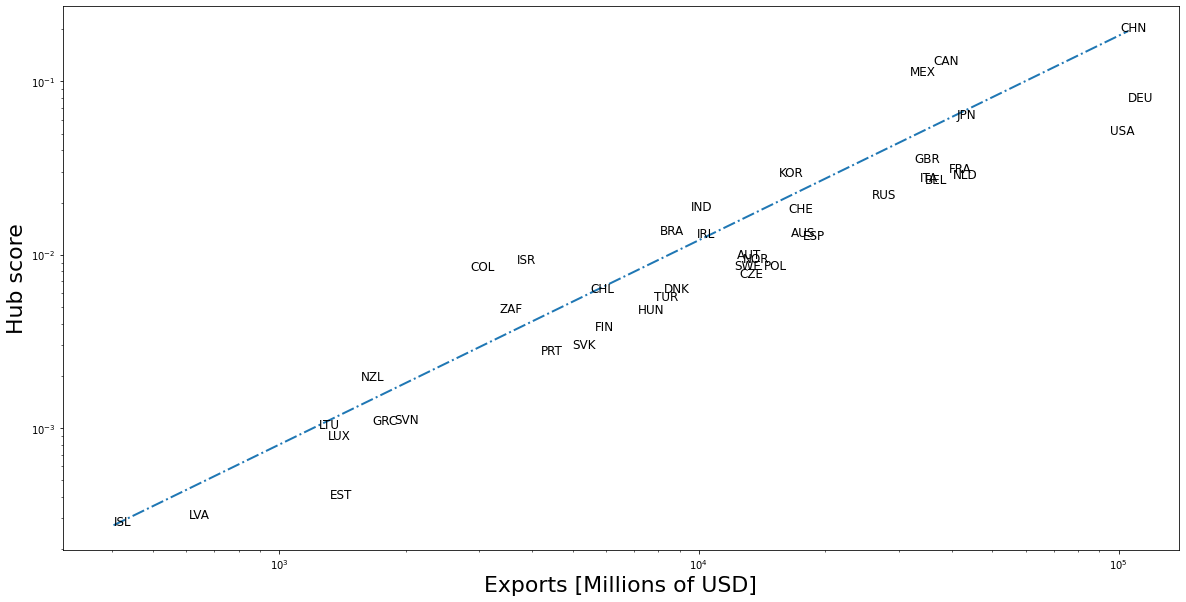

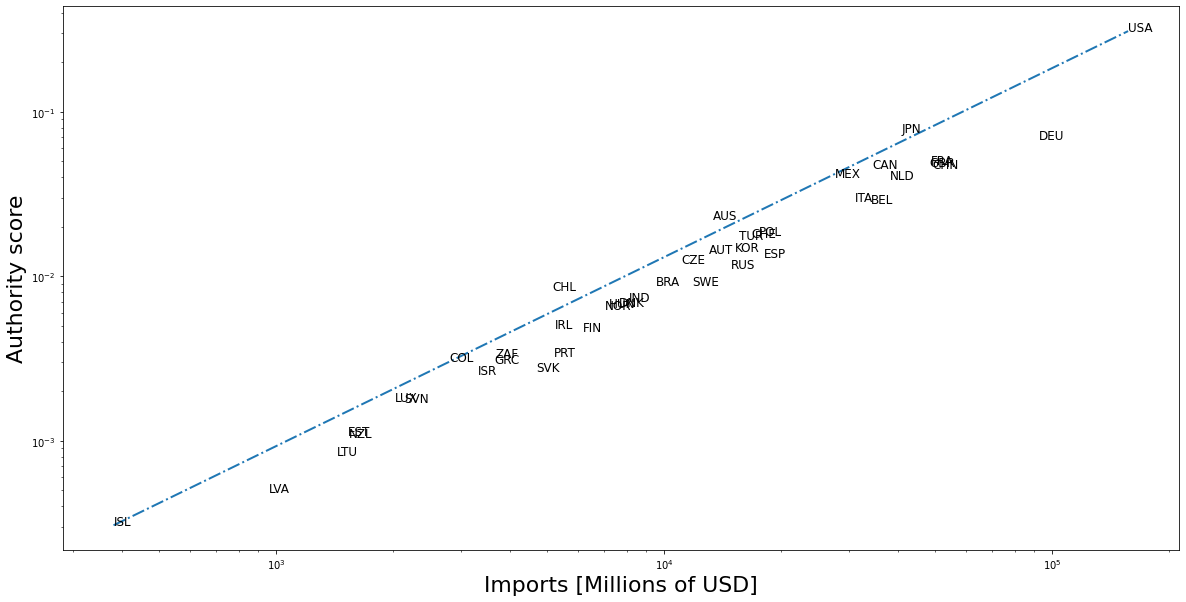

In [25]:
# LEAVE AS-IS: print plots for 2013

plot_scatter( exports2013, h2013, "Exports [Millions of USD]", "Hub score" )
plot_scatter( imports2013, a2013, "Imports [Millions of USD]", "Authority score" )

Viendo ambas representaciones, se puede ver como la relación entre los hub scores y exportaciones (a) es más dispersa, es decir, que está menos correlacionada que la relación entre authority scores y imports (b). Aún así, en ambos casos, se ve una clara relación entre ambas. Si bien en el caso a, están distribuidos tanto por encima como por debajo de la diagonal, en el segundo caso b están mayoritariamente distribuidos por debajo, lo que indica que, proporcionalmente, su authority score está por debajo de sus importaciones. 

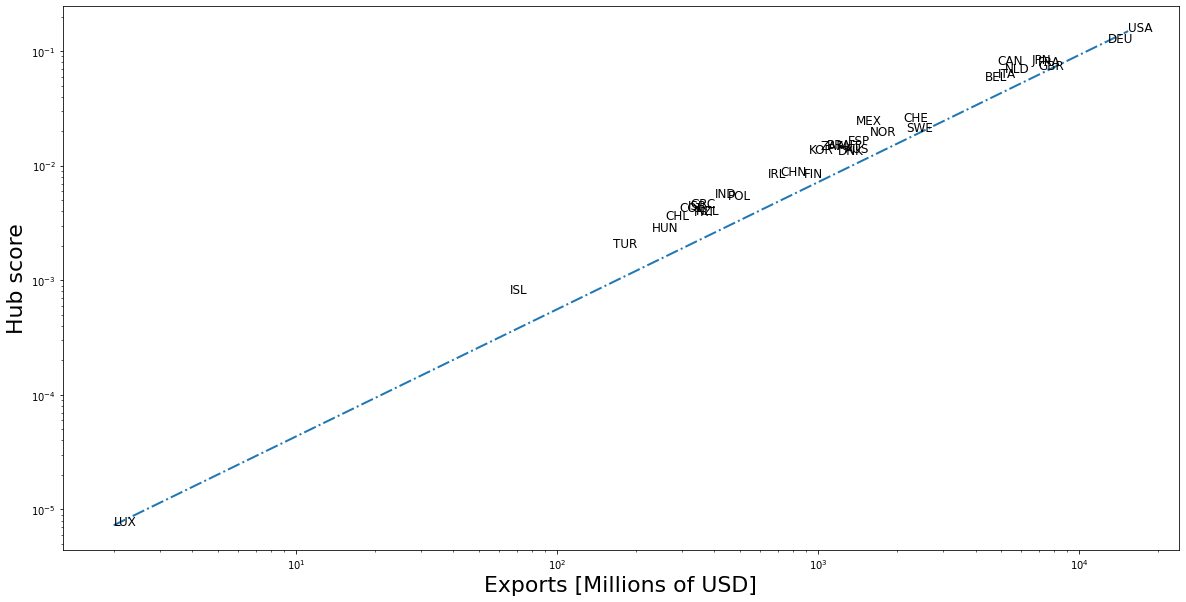

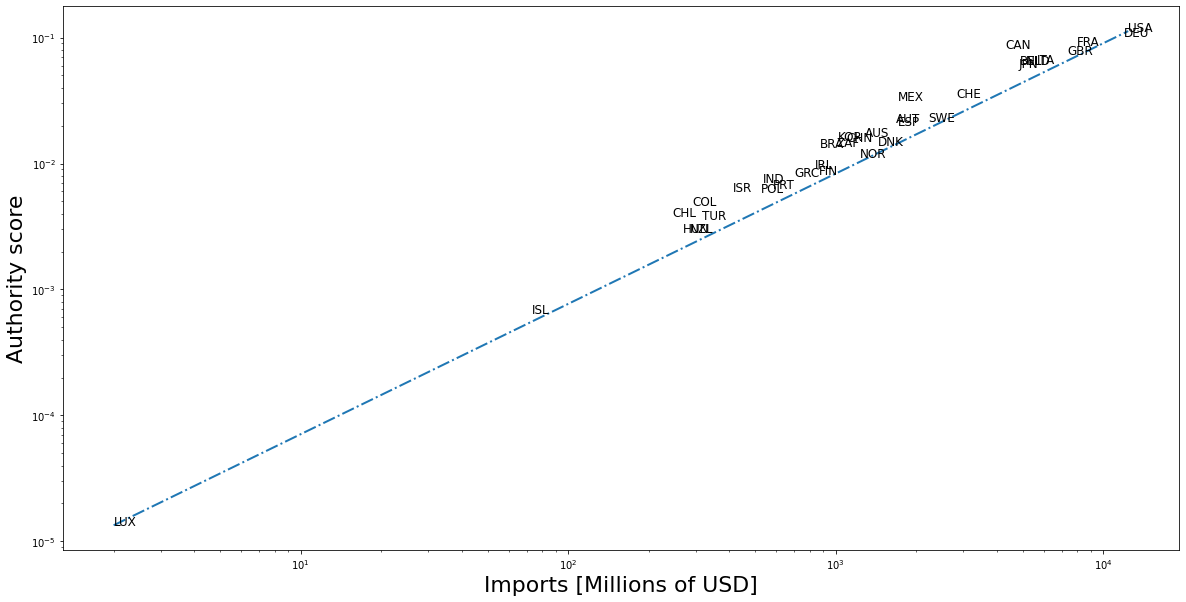

In [26]:
# LEAVE AS-IS: print plots for 1980

plot_scatter( exports1980, h1980, "Exports [Millions of USD]", "Hub score" )
plot_scatter( imports1980, a1980, "Imports [Millions of USD]", "Authority score" )

En 1980, a diferencia de 2013, podemos observar un fenómeno bastante curioso, y es que a parte de estar, en general menos distribuidos respecto a la diagonal, su tendencia es a poseer un score, tanto de hub como de authority superior a la que deberían por sus exportaciones e importaciones respectivamente.

In [27]:
# A pesar de solo representar un único grafo, el de 1980, el código está implementado
# mediante funciones para así poder representar el grafo de cualquier año

def graph_to_dataframe_edges(g,OUTPUT):
  with io.open(OUTPUT, "w") as fileout: # Crear nuevo csv
    edges = csv.writer(fileout, delimiter='\t', quotechar='"')
    edges.writerow(["Country 1", "Country 2", "Weight"])
    for exporter, importer, d in g.edges(data = True): # Itera por cada enlace del grafo
      trading_volume = d["weight"] # Volumen importaciones
      edges.writerow([exporter, importer, trading_volume])

def graph_to_dataframe(g, OUTPUT, id2name,  imp, exp, hub, aut):
  with io.open(OUTPUT, "w") as fileout: 
    data = csv.writer(fileout, delimiter='\t', quotechar='"')
    data.writerow(["Code", "Country", "Imports", "Exports","Hub Score","Autority Score"])
    for node in g.nodes():
      code = node 
      country = id2name[code]
      imports = imp[code]
      exports = exp[code]
      hub_score = hub[code]
      authority_score = aut[code]
      data.writerow([code, country, imports, exports, hub_score, authority_score])


In [28]:
# Aquí se crean los csv de 1980 y 2013, aunque solo utilizaremos este primero.

OUTPUT_EDGES_1980 = "1980_edges.csv"
OUTPUT_TRADE_1980 = "1980_trades.csv"

graph_to_dataframe_edges(g1980,OUTPUT_EDGES_1980)
graph_to_dataframe(g1980, OUTPUT_TRADE_1980, id2name, imports1980, exports1980, h1980, a1980)


OUTPUT_EDGES_2013 = "2013_edges.csv"
OUTPUT_TRADE_2013 = "2013_trades.csv"

graph_to_dataframe_edges(g2013,OUTPUT_EDGES_2013)
graph_to_dataframe(g2013, OUTPUT_TRADE_2013, id2name, imports2013, exports2013, h2013, a2013)



In [33]:
!["Relaciones comerciales en 1980"](https://drive.google.com/file/d/1euAUqsJz3EhHxC4c9fAw5sWzd-CXbehs/view?usp=sharing)

# Por si no se muestra el grafo, está en el zip de la práctica como 1980_trades.png


/bin/bash: -c: line 0: syntax error near unexpected token `https://drive.google.com/file/d/1euAUqsJz3EhHxC4c9fAw5sWzd-CXbehs/view?usp=sharing'
/bin/bash: -c: line 0: `["Relaciones comerciales en 1980"](https://drive.google.com/file/d/1euAUqsJz3EhHxC4c9fAw5sWzd-CXbehs/view?usp=sharing)'


Como se puede ver en el grafo, los nodos cuyo hub score es más alto son los mismos que se muestran en el top 5 del apartado anterior, entre estos destaca USA que lidera el cluster de comercio entre las Americas con Canada, Mexico, Colombia, etc. Y también con ciertas regiones de Europa y Asia, como Japon y China de esta última. Algo destacable es la poca relevancia que tiene China en cuanto a hub en 1980, cosa que cambiará drásticamente para 2013. Además podemos ver otro Cluster relevante(representado en gris), cuyo nodo de mayor hub score es Alemania, que principalmente se centra en Europa, y donde se encuentran relaciones comerciales de mucho peso, cuanto más oscuro el edge, mayor peso tiene el enlace. Un caso curioso es el de Luxemburgo, que a pesar de estar en Europa bastante céntrico sus relaciones comerciales son tan limitadas que pertenece a otro Cluster.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>